# Sperm Flagellum Tracking Notebook

### Modules to be imported

In [1]:
import os
import sys

sys.path.append(os.getcwd())

import numpy as np
import scipy as sp
import pylab as pl

from src.utils       import *
from src.segment     import Segment
from src.preprocess  import Preprocess
from src.reconstruct import Reconstruct

### Input parameters

In [2]:
directory = "..."
filename  = "flagellum"
fmt       = ".tif"  #image stack format

nframes   = 500

kwargs = {
    "min_bright"     : 0.45, #Brightness threshold used for img processing and segment location
    "rot_ang"        : 30,    # Angle to rotate imgs if needed
    "neigh_distance" : 2,    # Max distance to find neighbour points during segmentation
    "min_neighs"     : 1,    # Minimum number of neighbours 
}

## Load images

```load_images``` allows to n amount of pixels from the edges if ```crop = True```

In [3]:
img_stack = load_images(f"{directory}{filename}{fmt}",crop=True,cut_npx=2)

## Image pre-process

In [4]:
pp = Preprocess(imgs=img_stack,**kwargs)
pimgs = pp.process_img_stack()

In [5]:
#Z-positions are recovered from external piezo device
zfile = f"{directory}piezo_sequence.txt"

time,positions = load_piezo_actuation(zfile)
zpositions, timesteps = complete_z_positions(duration=time,positions=positions,nimgs=nframes)

## Image segmentation: separate head from flagellum

```Segment``` is a class object that detects the head and flagellum positions and matches with z-positions from external device.

Returns ```time_segements```, a dictionary containing posotions for head and flagellum

In [6]:
s = Segment(imgs=pimgs,zpositions=zpositions,timesteps=timesteps,**kwargs)
time_segments = s.run_segmentation_all()

The flagellum segements can be separated using ```segment_size``` which is usually larger for the flagellum

In [7]:
flagellum = s.find_all_segments_time(time_segments,segment_size=150)

## Segment reconstruction

In [8]:
r = Reconstruct(segment_data=time_segments,labelled_segments=flagellum,polynomial_degree=5)
reconst = r.process_all_segments()

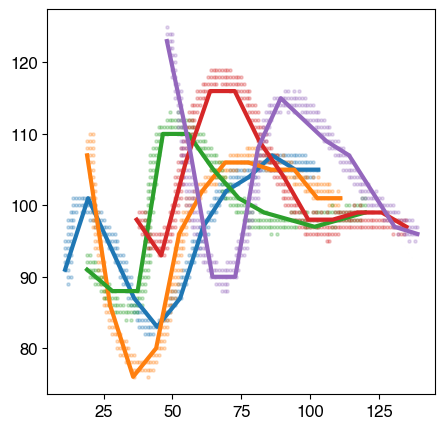

In [9]:
timesteps = [0,100,200,350,400]

for t in timesteps:
    pos = time_segments[t][flagellum[t]].get("pos")
    fit = reconst[t].get("fit")
    pl.scatter(pos[:,0],pos[:,1],s=5,alpha=0.25)
    pl.plot(fit[:,0],fit[:,1],lw=3)